# Product Demo for RapidScat Level 2A Surface Flagged Sigma-0 and Attenuations in 25km Swath Grid Version 2.0
## Plot all RapidScat orbits for a single day, colored by sigma-0

This short notebook gives a demo of downloading and plotting data for the RapidScat Level 2A (25 km) Surface Flagged Sigma-0 product: https://doi.org/10.5067/RSX25-L2A20. All orbits for March 03, 2016 are used (1 file per orbit, HDF-4 format). 

The demo first covers opening a file using the __[pyhdf](https://hdfeos.org/software/pyhdf.php)__ module, including looking at available variables and attributes within a variable. Then, scatter plots of orbit trajectories colored by sigma-0 are plotted (which involves accessing the data and applying the scale factors found in the respective variables' attributes).

In [1]:
import os
import gc
from pyhdf.SD import SD, SDC
import numpy as np
import matplotlib.pyplot as plt
import cartopy

%matplotlib inline

### Download the data files (9 total)

Download the files and place them in the same directory as this notebook. There are several options to get the data, two of which are listed here:

* The data files used in this demo can be found and downloaded on Earthdata Search: https://search.earthdata.nasa.gov/search/granules?p=C2633944811-POCLOUD&pg[0][v]=f&pg[0][qt]=2016-03-01T00%3A00%3A00.000Z%2C2016-03-01T23%3A59%3A59.999Z&pg[0][gsk]=-start_date&q=RSCAT_L2A_25KM&tl=1685996667.152!3!!

* Alternatively, they can be downloaded to the current directory with the PO.DAAC data-subscriber tool (https://github.com/podaac/data-subscriber) via the following command:
```
podaac-data-subscriber -c RSCAT_L2A_25KM_V2.0 -d ./ --extension hdf --start-date 2016-03-01T00:00:00Z --end-date 2016-03-02T00:00:00Z
```

### Load a file and check its contents
This notebook assumes that the only files in the same directory with `.hdf` extensions are rapidscat data files.

In [2]:
filenames = [f for f in os.listdir("./") if f.endswith('.hdf')]
filenames.sort()
filenames

['RS_S2A08158.20180190632.hdf',
 'RS_S2A08159.20180190632.hdf',
 'RS_S2A08160.20180190634.hdf',
 'RS_S2A08161.20180190635.hdf',
 'RS_S2A08162.20180190635.hdf',
 'RS_S2A08163.20180190636.hdf',
 'RS_S2A08164.20180190638.hdf',
 'RS_S2A08165.20180190638.hdf',
 'RS_S2A08166.20180190643.hdf']

In [3]:
# Load first file:
rscat_hdf = SD(filenames[0], SDC.READ)

In [4]:
# Print all variables, their shapes, and coordinates:
rscat_vars = rscat_hdf.datasets()
for k in rscat_vars:
    print(k)
    print("\t", rscat_vars[k][1], rscat_vars[k][0])

row_number
	 (1780,) ('Wind_Vector_Cell_Row',)
num_sigma0
	 (1780,) ('Wind_Vector_Cell_Row',)
num_sigma0_per_cell
	 (1780, 76) ('Wind_Vector_Cell_Row', 'Wind_Vector_Cell')
num_wvc_tb_in
	 (1780, 76) ('Wind_Vector_Cell_Row', 'Wind_Vector_Cell')
num_wvc_tb_out
	 (1780, 76) ('Wind_Vector_Cell_Row', 'Wind_Vector_Cell')
mean_wvc_tb_in
	 (1780, 76) ('Wind_Vector_Cell_Row', 'Wind_Vector_Cell')
mean_wvc_tb_out
	 (1780, 76) ('Wind_Vector_Cell_Row', 'Wind_Vector_Cell')
std_dev_wvc_tb_in
	 (1780, 76) ('Wind_Vector_Cell_Row', 'Wind_Vector_Cell')
std_dev_wvc_tb_out
	 (1780, 76) ('Wind_Vector_Cell_Row', 'Wind_Vector_Cell')
cell_lat
	 (1780, 810) ('Wind_Vector_Cell_Row', 'Sigma0_Cell')
cell_lon
	 (1780, 810) ('Wind_Vector_Cell_Row', 'Sigma0_Cell')
cell_azimuth
	 (1780, 810) ('Wind_Vector_Cell_Row', 'Sigma0_Cell')
cell_incidence
	 (1780, 810) ('Wind_Vector_Cell_Row', 'Sigma0_Cell')
sigma0
	 (1780, 810) ('Wind_Vector_Cell_Row', 'Sigma0_Cell')
sigma0_attn_amsr
	 (1780, 810) ('Wind_Vector_Cell_Row', 'Sig

**Check out attributes of sigma-0 variable**

In [5]:
sigma0 = rscat_hdf.select('sigma0')
sigma0.attributes()

{'long_name': 'sigma0',
 'units': 'dB',
 'valid_range': [-30000, 2000],
 'SDS_type': 'Single',
 'scale_factor': 0.01,
 'scale_factor_err': 0.0,
 'add_offset': 0.0,
 'add_offset_err': 0.0,
 'calibrated_nt': 1}

### Plot all orbits for the day colored by sigma-0

May take ~30 seconds to complete.

The latitude/longitude variable names are `cell_lat` and `cell_lon`.

[Text(0, -60, '-60$^\\circ$'),
 Text(0, -30, '-30$^\\circ$'),
 Text(0, 0, '0$^\\circ$'),
 Text(0, 30, '30$^\\circ$'),
 Text(0, 60, '60$^\\circ$')]

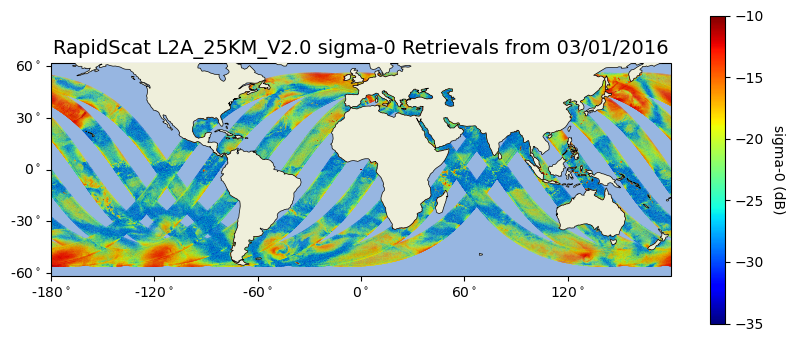

In [6]:
fig = plt.figure(figsize=(10, 4))
ax = plt.axes(projection=cartopy.crs.PlateCarree(central_longitude=0))


for fn in filenames[:]:
    
    # Load data, get lat, lon, sigma-0. Get data arrays and apply scale factors:
    rscat_hdf = SD(fn, SDC.READ)  
    sigma0 = rscat_hdf.select('sigma0')
    sigma0_data = sigma0[:]*sigma0.attributes()['scale_factor']

    lon = rscat_hdf.select('cell_lon')
    lon_data = lon[:]*lon.attributes()['scale_factor']

    lat = rscat_hdf.select('cell_lat')
    lat_data = lat[:]*lat.attributes()['scale_factor']

    # Scatter plot:
    s = ax.scatter(
        lon_data.flatten(), lat_data.flatten(), c=sigma0_data.flatten(), 
        cmap='jet', vmin=-35, vmax=-10, s=0.1, marker='.', linewidths=0
        )
    
    # Free up memory:
    del rscat_hdf, sigma0_data, lat_data, lon_data
    gc.collect()
    

# Shading for oceans/continents and outlines for coastlines
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black', linewidth=0.5)


# Colorbar and plotting aesthetics:
cbar = fig.colorbar(s, ax=ax)
cbar.set_label('sigma-0 (dB)', rotation=270, labelpad=15)
ax.set_title('RapidScat L2A_25KM_V2.0 sigma-0 Retrievals from 03/01/2016', fontsize=14)
xticks = np.arange(-180, 179, 60)
ax.set_xticks(xticks, crs=cartopy.crs.PlateCarree())
ax.set_xticklabels(str(t)+r"$^\circ$" for t in xticks)
yticks = np.arange(-60, 61, 30)
ax.set_yticks(yticks, crs=cartopy.crs.PlateCarree())
ax.set_yticklabels(str(t)+r"$^\circ$" for t in yticks)